# Load ads

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'. Needed to remove SettingWithCopyWarning warning when assigning new value to dataframe column
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

import statsmodels.formula.api as smf
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2

# from housing_crawler.utils import save_file, get_file, get_grid_polygons_all_cities
from housing_crawler.analysis.ads_table_processing import get_processed_ads_table
from housing_crawler.string_utils import remove_prefix, simplify_address, standardize_characters, capitalize_city_name, german_characters
from housing_crawler.utils import standardize_features, return_significative_coef


from config.config import ROOT_DIR
from housing_crawler.params import dict_city_number_wggesucht

In [2]:
ads_feat_df = get_processed_ads_table(update_table=True)
list(ads_feat_df.columns)

===> Loaded all_encoded.csv locally
===> ads_OSM.csv saved locally


['id',
 'url',
 'commercial_landlord',
 'title',
 'price_euros',
 'size_sqm',
 'available_rooms',
 'capacity',
 'available_spots_wg',
 'male_flatmates',
 'female_flatmates',
 'diverse_flatmates',
 'published_on',
 'published_at',
 'address',
 'city',
 'crawler',
 'latitude',
 'longitude',
 'available_from',
 'available_to',
 'details_searched',
 'cold_rent_euros',
 'mandatory_costs_euros',
 'extra_costs_euros',
 'schufa_needed',
 'deposit',
 'zip_code',
 'home_total_size',
 'smoking',
 'energy',
 'wg_possible',
 'building_type',
 'building_floor',
 'furniture',
 'kitchen',
 'shower_type',
 'floor_type',
 'heating',
 'public_transport_distance',
 'internet',
 'parking',
 'transfer_costs_euros',
 'type_offer_simple',
 'min_age_flatmates',
 'max_age_flatmates',
 'gender_searched',
 'min_age_searched',
 'max_age_searched',
 'number_languages',
 'extras_waschmaschine',
 'extras_spuelmaschine',
 'extras_terrasse',
 'extras_balkon',
 'extras_garten',
 'extras_gartenmitbenutzung',
 'extras_kel

In [3]:
# Number of duplicate data points
# It's very likely zero cause I already removed dulicated IDs during processing
ads_feat_df.duplicated().sum()

0

In [4]:
# Percentage missing values per column
(ads_feat_df.isnull().sum().sort_values(ascending=False)/len(ads_feat_df)*100)[0:30]

energy                       94.599029
shower_type                  88.851300
heating                      88.428424
home_total_size              88.233901
max_age_flatmates            87.638492
min_age_flatmates            86.620207
internet                     86.330960
parking                      85.004821
floor_type                   83.157699
building_type                80.260153
public_transport_distance    79.421167
building_floor               77.912346
zip_code                     75.452900
extras_keller                75.410612
extras_gartenmitbenutzung    75.410612
extras_garten                75.410612
extras_spuelmaschine         75.410612
extras_balkon                75.410612
extras_terrasse              75.410612
min_age_searched             75.410612
extras_waschmaschine         75.410612
max_age_searched             75.410612
extras_aufzug                75.410612
languages_englisch           75.410612
extras_fahrradkeller         75.410612
extras_dachboden         

# Creating WG, single-room and multi-room dataframes

In [5]:
wg_df = ads_feat_df.query('type_offer_simple == "WG"').reset_index().drop(columns=['index'])

singleroom_df = ads_feat_df.query('type_offer_simple == "Single-room flat"').reset_index().drop(columns=['index'])

flathouse_df = ads_feat_df.query('(type_offer_simple == "Apartment")').reset_index().drop(columns=['index'])

# Linear model WG

In [36]:
wg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43587 entries, 0 to 43586
Columns: 125 entries, id to cos_day_week_int
dtypes: Float64(2), Int64(1), datetime64[ns](3), float64(96), int64(6), object(17)
memory usage: 41.7+ MB


In [37]:
# define columns to work
features = [
    'km_to_centroid',
    'sin_degrees_to_centroid',
    'cos_degrees_to_centroid',
    
    'comfort_leisure_spots',
    'comfort_warehouse',
    'activities_education',
    'mobility_public_transport_bus',
    'activities_economic',
    'comfort_industrial',
    'activities_goverment',
    'social_life_eating',
    'comfort_comfort_spots',
    'social_life_culture',
    'activities_supermarket',
##     'activities_public_service',
    'social_life_community',
    'comfort_leisure_mass',
    'activities_educational',
    'mobility_street_secondary',
    'mobility_public_transport_rail',
    'activities_retail',
    'social_life_night_life',
    'comfort_green_natural',
    'comfort_railway',
    'mobility_bike_infraestructure',
##     'comfort_green_forests',
    'mobility_street_primary',
    'comfort_lakes',
##     'activities_health_regional',
    'activities_health_local',
    'comfort_green_space',
    'comfort_rivers',
    'activities_post',
    'comfort_green_parks',
    'comfort_street_motorway'
]

target = 'price_per_sqm'

selected_num_features = [
#             'days_available',
            'capacity',
#             'male_flatmates',
#             'female_flatmates',
#             'diverse_flatmates',
    
#             'cold_rent_euros',
#             'mandatory_costs_euros',
#             'extra_costs_euros',
            'transfer_costs_euros',
#             'deposit',
    
            'furniture',
            'kitchen',
#             'public_transport_distance',
#             'home_total_size',
            'smoking',
            'building_floor',
    
#             'min_age_flatmates',
#             'max_age_flatmates',
    
            'min_age_searched',
            'max_age_searched',
    
            'number_languages',
    
#             'sin_published_at',
#             'cos_published_at',
#             'sin_day_week_int',
#             'cos_day_week_int'
    
] + features
selected_cat_features = ['city',
                         'commercial_landlord',
            'rental_length_term',
#             'energy',
#             'wg_possible',
            'building_type',
#             'shower_type',
#             'floor_type',
#             'heating',
#             'internet',
#             'parking',
                         
            'schufa_needed',
                         
            'extras_waschmaschine',
            'extras_spuelmaschine',
            'extras_terrasse',
            'extras_balkon',
            'extras_garten',
            'extras_gartenmitbenutzung',
            'extras_keller',
            'extras_aufzug',
            'extras_haustiere',
            'extras_fahrradkeller',
            'extras_dachboden',
                         
#             'languages_deutsch',
#             'languages_englisch',
                         
            'wg_type_studenten',
            'wg_type_keine_zweck',
            'wg_type_maenner',
            'wg_type_business',
            'wg_type_wohnheim',
            'wg_type_vegetarisch_vegan',
            'wg_type_alleinerziehende',
            'wg_type_funktionale',
            'wg_type_berufstaetigen',
            'wg_type_gemischte',
            'wg_type_mit_kindern',
            'wg_type_verbindung',
            'wg_type_lgbtqia',
            'wg_type_senioren',
            'wg_type_inklusive',
            'wg_type_wg_neugruendung',
                         
#             'tv_kabel',
#             'tv_satellit',
                         
            'gender_searched',
                         
#             'age_category_searched'
                        ]
all_columns = [target] + selected_num_features + selected_cat_features

columns_to_zscore = selected_num_features


# Filter dataframe for modelling
df_zscored = wg_df[all_columns#+['city']
                     ].copy()

df_zscored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43587 entries, 0 to 43586
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   price_per_sqm              43587 non-null  float64
 1   capacity                   43587 non-null  float64
 2   transfer_costs_euros       10357 non-null  float64
 3   furniture                  10357 non-null  float64
 4   kitchen                    10357 non-null  float64
 5   smoking                    10357 non-null  float64
 6   building_floor             9282 non-null   float64
 7   min_age_searched           10357 non-null  float64
 8   max_age_searched           10357 non-null  float64
 9   number_languages           10357 non-null  float64
 10  km_to_centroid             20987 non-null  float64
 11  city                       43587 non-null  object 
 12  commercial_landlord        43587 non-null  int64  
 13  rental_length_term         43587 non-null  obj

In [38]:
df_zscored = df_zscored.dropna(axis=0)
# z-scoring columns
df_zscored = standardize_features(df_zscored, columns_to_zscore)

# Filter table if needed
df_city = df_zscored#[df_zscored['city'] == 'Leipzig']
df_city.shape

(3887, 44)

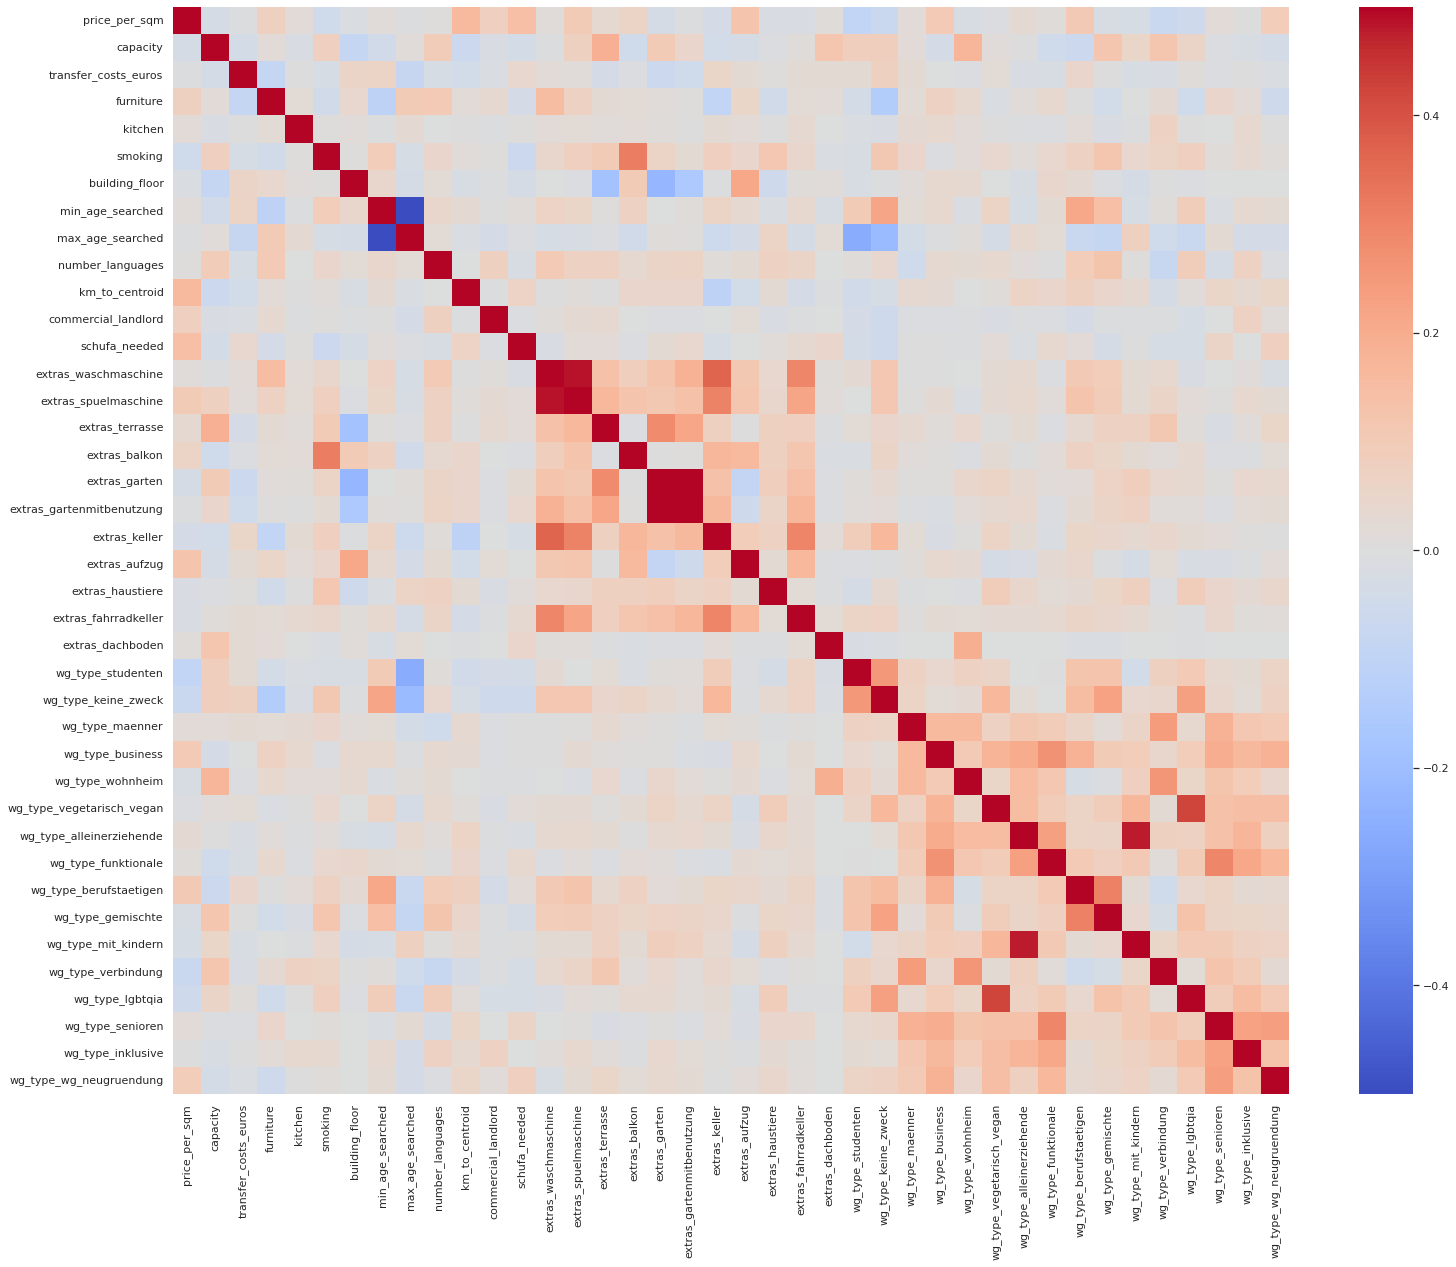

In [39]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(25, 20))

sns.heatmap(df_city.corr(), cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-0.5, vmax=0.5);

In [40]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()

df["features"] = columns_to_zscore

df["vif_index"] = [vif(df_city[columns_to_zscore].values, i) for i in range(df_city[columns_to_zscore].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)

,features,vif_index
6,min_age_searched,2.52
7,max_age_searched,2.49
2,furniture,1.04
8,number_languages,1.03
0,capacity,1.03
4,smoking,1.03
1,transfer_costs_euros,1.02
5,building_floor,1.02
9,km_to_centroid,1.01
3,kitchen,1.00


In [41]:
# OLS model
formula = target + ' ~ ' + ' + '.join(selected_num_features) + ' + ' + ' + '.join(['C('+feat+')-1' for feat in selected_cat_features]) + '-1'

model_city = smf.ols(formula = formula, data=df_city).fit()
model_city.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          price_per_sqm   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     25.87
Date:                Thu, 25 Aug 2022   Prob (F-statistic):          9.69e-290
Time:                        19:45:41   Log-Likelihood:                -14310.
No. Observations:                3887   AIC:                         2.878e+04
Df Residuals:                    3808   BIC:                         2.927e+04
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
C(city)[Aachen]                         19.6148      2.651      7.398      0.000      14.416      24.813
C(city)[Berlin]                         25.8224      2.497     10.342      0.000      20.927      30.718
C(city)[Bonn]                           21.1005      2.715      7.770      0.000      15.776      26.424
C(city)[Bremen]                         19.9414      2.660      7.496      0.000      14.726      25.157
C(city)[Darmstadt]                      20.6109      2.734      7.539      0.000      15.251      25.971
C(city)[Dresden]                        14.5645      2.612      5.576      0.000       9.443      19.686
C(city)[Frankfurt am Main]              26.2009      2.594     10.102      0.000      21.116      31.286
C(city)[Göttingen]                      15.8803      2.704      5.873      0.000      10.579      21.182
C(city)[Hamburg]                        35.6842      2.842     12.558      0.000      30.113      41.255
C(city)[Hannover]                       19.1435      2.622      7.301      0.000      14.002      24.284
C(city)[Heidelberg]                     22.3814      2.715      8.243      0.000      17.058      27.705
C(city)[Karlsruhe]                      18.8380      2.607      7.225      0.000      13.726      23.950
C(city)[Kiel]                           15.9905      2.806      5.698      0.000      10.489      21.492
C(city)[Köln]                           24.8295      2.565      9.680      0.000      19.801      29.858
C(city)[Leipzig]                        15.0876      2.540      5.940      0.000      10.108      20.067
C(city)[Mainz]                          22.5627      2.702      8.350      0.000      17.265      27.861
C(city)[Mannheim]                       19.6361      2.790      7.039      0.000      14.167      25.106
C(city)[München]                        37.0273      2.533     14.616      0.000      32.061      41.994
C(city)[Münster]                        18.9794      2.666      7.119      0.000      13.753      24.206
C(city)[Nürnberg]                       19.0964      2.795      6.833      0.000      13.617      24.575
C(city)[Regensburg]                     21.2716      2.824      7.532      0.000      15.735      26.809
C(city)[Stuttgart]                      26.5530      2.545     10.435      0.000      21.564      31.542
C(city)[Tübingen]                       22.4921      3.021      7.445      0.000      16.569      28.415
C(city)[Würzburg]                       18.7442      2.740      6.840      0.000      13.372      24.117
C(commercial_landlord)[T.1]              9.1717      2.295      3.996      0.000       4.672      13.671
C(rental_length_term)[T.<270days]       -0.5105      0.778     -0.656      0.512      -2.036       1.015
C(rental_length_term)[T.<365days]     

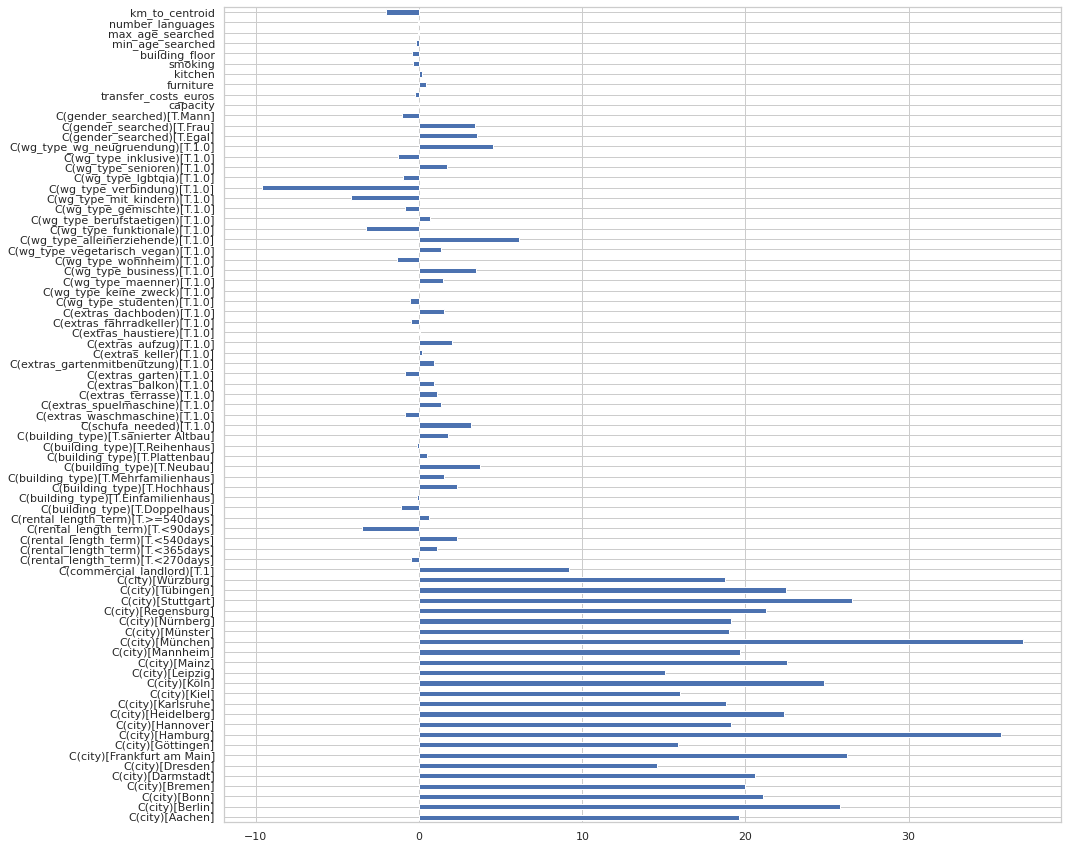

In [42]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model_city.params[0:].plot(kind='barh');

RMSE: 9.60805546424293
RMSE base model: 11.884199370660403


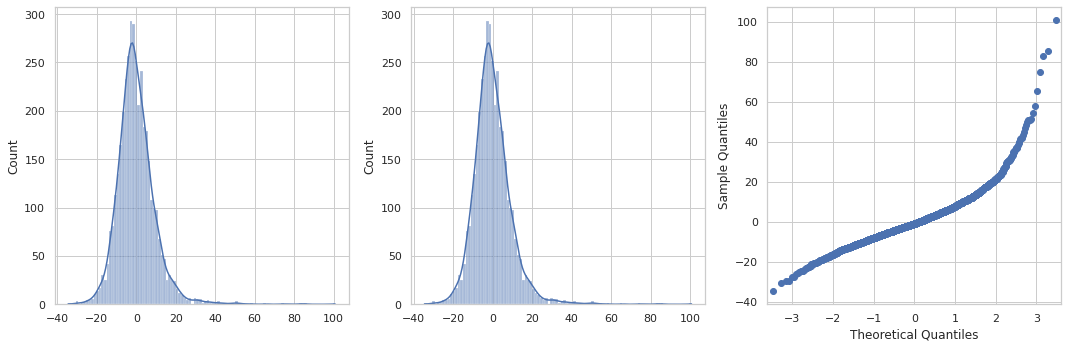

In [43]:
y_pred = model_city.predict(df_city)
y_base = [np.mean(df_city['price_per_sqm'])]*len(y_pred)
y_true = df_city['price_per_sqm']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_city)
residuals = y_pred - y_true
residuals_base = y_pred - y_true
# residuals.std()/orders.delay_vs_expected.std() * 1/(n**0.5)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(-residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(-residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model_city.resid, ax=ax3)
plt.tight_layout()
fig.show();

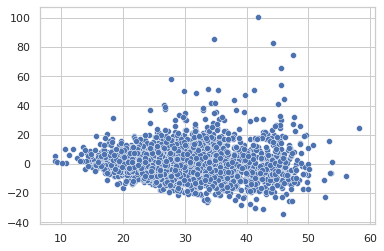

In [44]:
sns.scatterplot(x=model_city.predict(df_city), y=model_city.resid);

                                           p_value       coef
variable                                                     
C(city)[München]                      4.093084e-47  37.027300
C(city)[Hamburg]                      1.798210e-35  35.684247
C(city)[Stuttgart]                    3.735878e-25  26.552959
C(city)[Frankfurt am Main]            1.069208e-23  26.200850
C(city)[Berlin]                       9.672183e-25  25.822363
C(city)[Köln]                         6.516927e-22  24.829456
C(city)[Mainz]                        9.466959e-17  22.562709
C(city)[Tübingen]                     1.189540e-13  22.492072
C(city)[Heidelberg]                   2.295160e-16  22.381377
C(city)[Regensburg]                   6.206305e-14  21.271641
C(city)[Bonn]                         9.994010e-15  21.100462
C(city)[Darmstadt]                    5.906572e-14  20.610907
C(city)[Bremen]                       8.112606e-14  19.941383
C(city)[Mannheim]                     2.288400e-12  19.636127
C(city)[

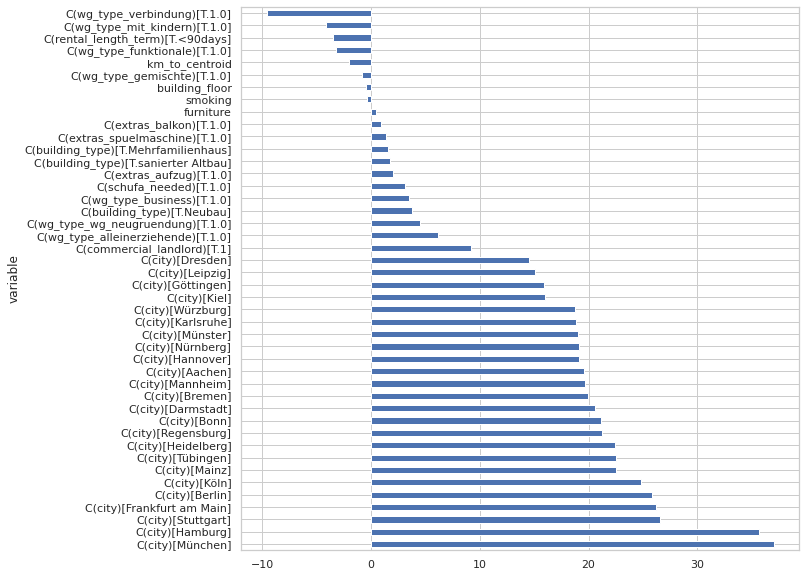

In [45]:
df = return_significative_coef(model_city).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef.plot(kind='barh');

# Linear model Apartment

In [46]:
flathouse_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8054 entries, 0 to 8053
Columns: 125 entries, id to cos_day_week_int
dtypes: Float64(2), Int64(1), datetime64[ns](3), float64(96), int64(6), object(17)
memory usage: 7.7+ MB


In [47]:
# define columns to work
features = [
    'km_to_centroid',
    'sin_degrees_to_centroid',
    'cos_degrees_to_centroid',
    
    'comfort_leisure_spots',
    'comfort_warehouse',
    'activities_education',
    'mobility_public_transport_bus',
    'activities_economic',
    'comfort_industrial',
    'activities_goverment',
    'social_life_eating',
    'comfort_comfort_spots',
    'social_life_culture',
    'activities_supermarket',
##     'activities_public_service',
    'social_life_community',
    'comfort_leisure_mass',
    'activities_educational',
    'mobility_street_secondary',
    'mobility_public_transport_rail',
    'activities_retail',
    'social_life_night_life',
    'comfort_green_natural',
    'comfort_railway',
    'mobility_bike_infraestructure',
##     'comfort_green_forests',
    'mobility_street_primary',
    'comfort_lakes',
##     'activities_health_regional',
    'activities_health_local',
    'comfort_green_space',
    'comfort_rivers',
    'activities_post',
    'comfort_green_parks',
    'comfort_street_motorway'
]

target = 'price_per_sqm'

selected_num_features = [
#             'days_available',
            'available_rooms',
#             'capacity',
#             'male_flatmates',
#             'female_flatmates',
#             'diverse_flatmates',
    
#             'cold_rent_euros',
#             'mandatory_costs_euros',
#             'extra_costs_euros',
            'transfer_costs_euros',
#             'deposit',

            'building_floor',
            'furniture',
            'kitchen',
#             'public_transport_distance',
#             'home_total_size',
#             'smoking',
    
#             'min_age_flatmates',
#             'max_age_flatmates',
    
#             'min_age_searched',
#             'max_age_searched',
    
#             'number_languages',
    
#             'sin_published_at',
#             'cos_published_at',
#             'sin_day_week_int',
#             'cos_day_week_int'
    
] + features
selected_cat_features = ['city',
                         'commercial_landlord',
            'rental_length_term',
#             'energy',
            'wg_possible',
            'building_type',
#             'shower_type',
#             'floor_type',
#             'heating',
#             'internet',
#             'parking',
                         
            'schufa_needed',
                         
            'extras_waschmaschine',
            'extras_spuelmaschine',
            'extras_terrasse',
            'extras_balkon',
            'extras_garten',
            'extras_gartenmitbenutzung',
            'extras_keller',
            'extras_aufzug',
            'extras_haustiere',
            'extras_fahrradkeller',
            'extras_dachboden',
                         
#             'languages_deutsch',
#             'languages_englisch',
                         
#             'wg_type_studenten',
#             'wg_type_keine_zweck',
#             'wg_type_maenner',
#             'wg_type_business',
#             'wg_type_wohnheim',
#             'wg_type_vegetarisch_vegan',
#             'wg_type_alleinerziehende',
#             'wg_type_funktionale',
#             'wg_type_berufstaetigen',
#             'wg_type_gemischte',
#             'wg_type_mit_kindern',
#             'wg_type_verbindung',
#             'wg_type_lgbtqia',
#             'wg_type_senioren',
#             'wg_type_inklusive',
#             'wg_type_wg_neugruendung',
                         
            'tv_kabel',
            'tv_satellit',
                         
#             'gender_searched',
                         
#             'age_category_searched'
                        ]
all_columns = [target] + selected_num_features + selected_cat_features

columns_to_zscore = selected_num_features


# Filter dataframe for modelling
df_zscored = flathouse_df[all_columns#+['city']
                     ].copy()

df_zscored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8054 entries, 0 to 8053
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   price_per_sqm              8054 non-null   float64
 1   available_rooms            8054 non-null   float64
 2   transfer_costs_euros       2294 non-null   float64
 3   building_floor             2114 non-null   float64
 4   furniture                  2294 non-null   float64
 5   kitchen                    2294 non-null   float64
 6   km_to_centroid             3875 non-null   float64
 7   city                       8054 non-null   object 
 8   commercial_landlord        8054 non-null   int64  
 9   rental_length_term         8054 non-null   object 
 10  wg_possible                2294 non-null   float64
 11  building_type              1989 non-null   object 
 12  schufa_needed              2294 non-null   float64
 13  extras_waschmaschine       2294 non-null   float

In [48]:
df_zscored = df_zscored.dropna(axis=0)
# z-scoring columns
df_zscored = standardize_features(df_zscored, columns_to_zscore)

# Filter table if needed
df_city = df_zscored#[df_zscored['city'] == 'Leipzig']
df_city.shape

(907, 26)

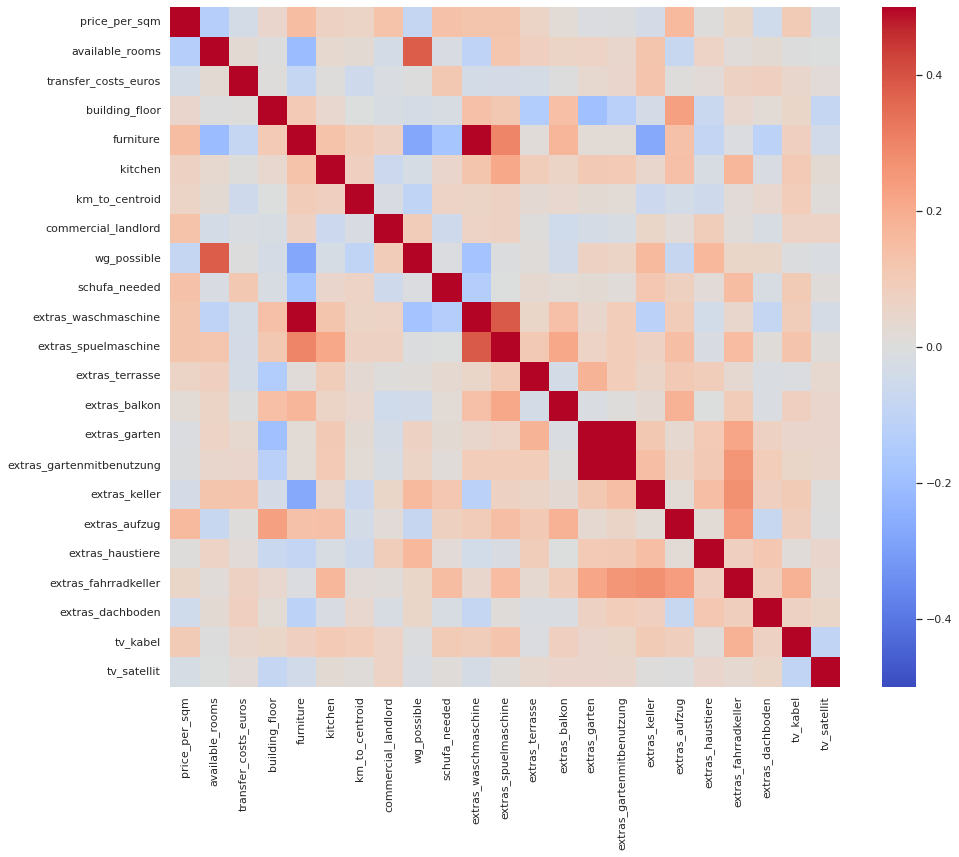

In [49]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 12.5))

sns.heatmap(df_city.corr(), cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-0.5, vmax=0.5);

In [50]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()

df["features"] = columns_to_zscore

df["vif_index"] = [vif(df_city[columns_to_zscore].values, i) for i in range(df_city[columns_to_zscore].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)

,features,vif_index
3,furniture,1.09
0,available_rooms,1.05
4,kitchen,1.03
5,km_to_centroid,1.02
2,building_floor,1.01
1,transfer_costs_euros,1.01


In [51]:
# OLS model
formula = target + ' ~ ' + ' + '.join(selected_num_features) + ' + ' + ' + '.join(['C('+feat+')-1' for feat in selected_cat_features]) + '-1'

model_city = smf.ols(formula = formula, data=df_city).fit()
model_city.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          price_per_sqm   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     7.197
Date:                Thu, 25 Aug 2022   Prob (F-statistic):           2.27e-43
Time:                        19:45:44   Log-Likelihood:                -2719.9
No. Observations:                 907   AIC:                             5558.
Df Residuals:                     848   BIC:                             5842.
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
C(city)[Aachen]                         12.0645      1.175     10.269      0.000       9.759      14.370
C(city)[Berlin]                         16.0853      0.803     20.040      0.000      14.510      17.661
C(city)[Bonn]                           14.9616      1.642      9.111      0.000      11.738      18.185
C(city)[Bremen]                         14.8436      1.903      7.800      0.000      11.108      18.579
C(city)[Darmstadt]                      16.5589      1.851      8.947      0.000      12.926      20.192
C(city)[Dresden]                        10.2810      1.260      8.157      0.000       7.807      12.755
C(city)[Frankfurt am Main]              18.1550      1.114     16.298      0.000      15.969      20.341
C(city)[Göttingen]                      12.7939      1.547      8.271      0.000       9.758      15.830
C(city)[Hamburg]                        21.7034      1.820     11.928      0.000      18.132      25.275
C(city)[Hannover]                       12.4854      1.279      9.758      0.000       9.974      14.997
C(city)[Heidelberg]                     15.7792      1.928      8.183      0.000      11.994      19.564
C(city)[Karlsruhe]                      12.4273      2.071      6.000      0.000       8.362      16.492
C(city)[Kiel]                           12.0392      3.057      3.938      0.000       6.039      18.040
C(city)[Köln]                           17.5043      0.968     18.074      0.000      15.603      19.405
C(city)[Leipzig]                         9.3068      1.150      8.093      0.000       7.050      11.564
C(city)[Mainz]                          15.4247      1.696      9.095      0.000      12.096      18.753
C(city)[Mannheim]                       12.6192      1.475      8.553      0.000       9.724      15.515
C(city)[München]                        20.8326      0.990     21.043      0.000      18.889      22.776
C(city)[Münster]                        13.9378      1.789      7.789      0.000      10.426      17.450
C(city)[Nürnberg]                       12.2127      1.483      8.235      0.000       9.302      15.123
C(city)[Regensburg]                     12.8968      2.018      6.391      0.000       8.936      16.858
C(city)[Stuttgart]                      17.5185      1.102     15.898      0.000      15.356      19.681
C(city)[Tübingen]                       20.8550      3.012      6.925      0.000      14.944      26.766
C(city)[Würzburg]                       14.3086      1.851      7.731      0.000      10.676      17.941
C(commercial_landlord)[T.1]              5.4906      1.880      2.920      0.004       1.800       9.181
C(rental_length_term)[T.<270days]        0.4510      0.805      0.560      0.576      -1.130       2.032
C(rental_length_term)[T.<365days]     

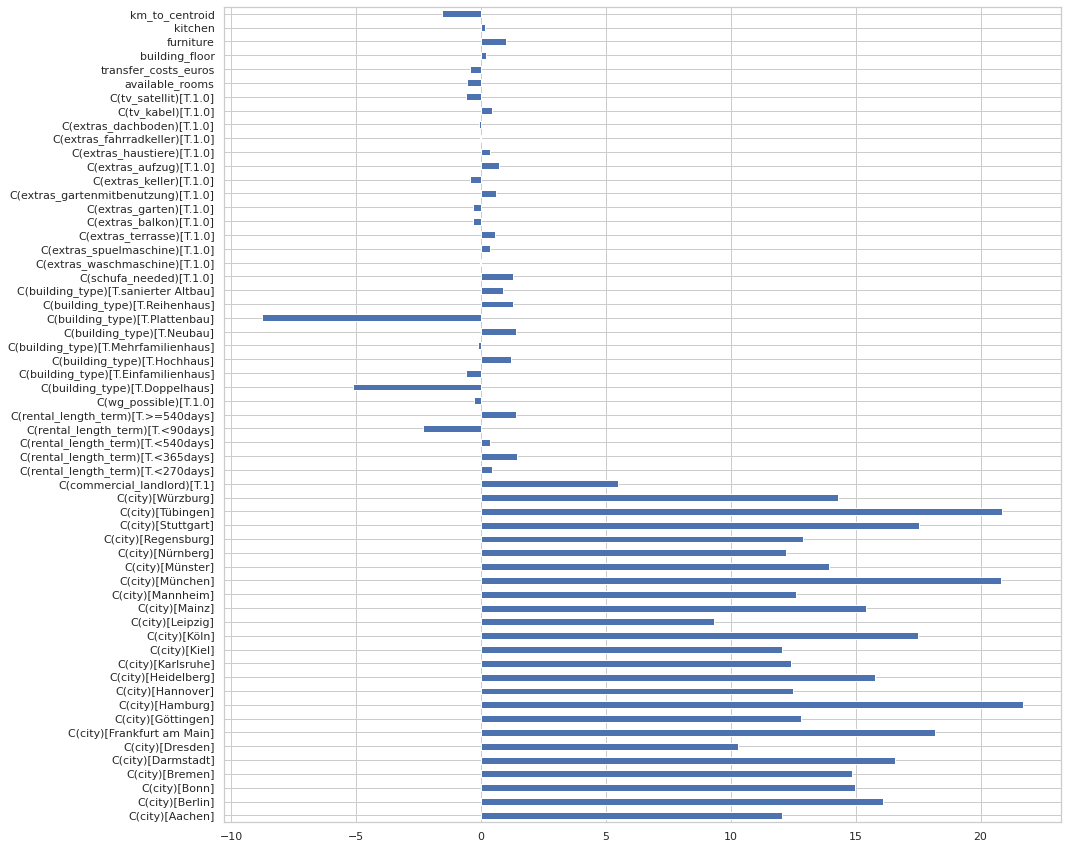

In [52]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model_city.params[0:].plot(kind='barh');

RMSE: 4.854475512866569
RMSE base model: 5.9300950249926165


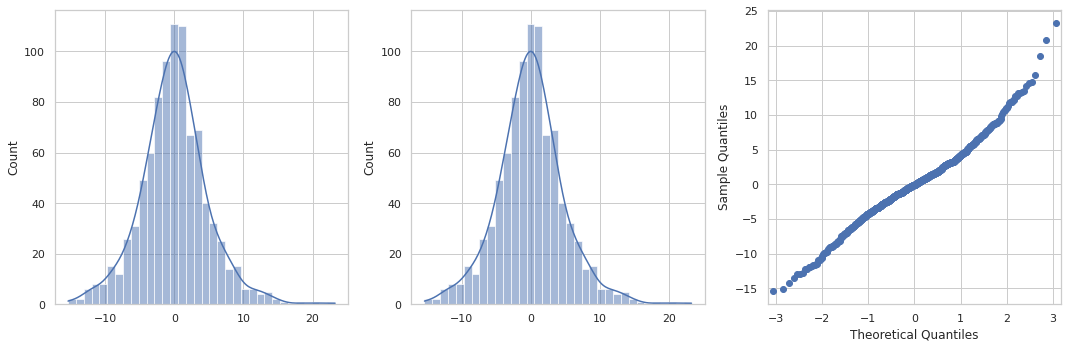

In [53]:
y_pred = model_city.predict(df_city)
y_base = [np.mean(df_city['price_per_sqm'])]*len(y_pred)
y_true = df_city['price_per_sqm']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_city)
residuals = y_pred - y_true
residuals_base = y_pred - y_true
# residuals.std()/orders.delay_vs_expected.std() * 1/(n**0.5)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(-residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(-residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model_city.resid, ax=ax3)
plt.tight_layout()
fig.show();

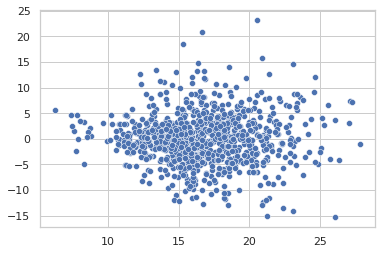

In [54]:
sns.scatterplot(x=model_city.predict(df_city), y=model_city.resid);

                                         p_value       coef
variable                                                   
C(city)[Hamburg]                    1.974544e-30  21.703363
C(city)[Tübingen]                   8.628405e-12  20.855000
C(city)[München]                    2.016773e-79  20.832644
C(city)[Frankfurt am Main]          3.695420e-52  18.155031
C(city)[Stuttgart]                  5.214270e-50  17.518522
C(city)[Köln]                       5.133917e-62  17.504299
C(city)[Darmstadt]                  2.260422e-18  16.558915
C(city)[Berlin]                     1.956702e-73  16.085348
C(city)[Heidelberg]                 1.009123e-15  15.779179
C(city)[Mainz]                      6.570917e-19  15.424732
C(city)[Bonn]                       5.770507e-19  14.961627
C(city)[Bremen]                     1.820722e-14  14.843646
C(city)[Würzburg]                   3.013594e-14  14.308609
C(city)[Münster]                    1.964101e-14  13.937790
C(city)[Regensburg]                 2.72

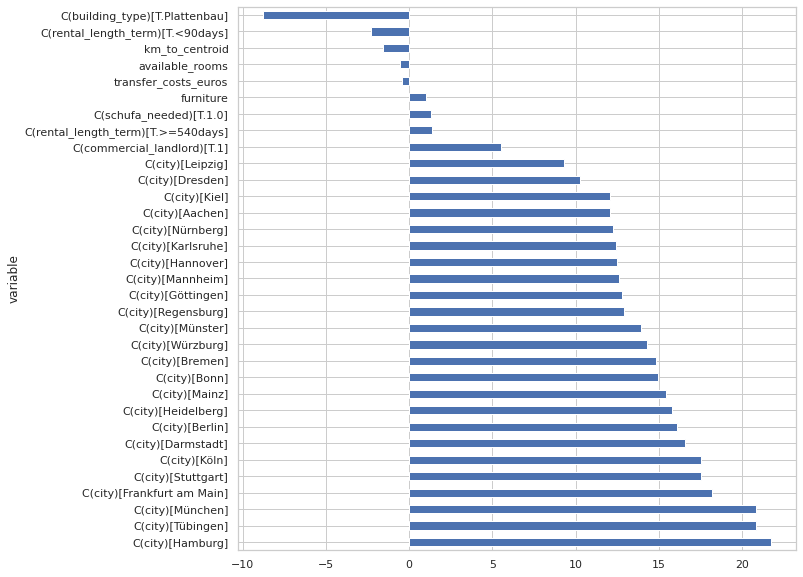

In [55]:
df = return_significative_coef(model_city).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef.plot(kind='barh');

# Linear model Single-room flats

In [56]:
singleroom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7478 entries, 0 to 7477
Columns: 125 entries, id to cos_day_week_int
dtypes: Float64(2), Int64(1), datetime64[ns](3), float64(96), int64(6), object(17)
memory usage: 7.2+ MB


In [57]:
# define columns to work
features = [
    'km_to_centroid',
    'sin_degrees_to_centroid',
    'cos_degrees_to_centroid',
    
    'comfort_leisure_spots',
    'comfort_warehouse',
    'activities_education',
    'mobility_public_transport_bus',
    'activities_economic',
    'comfort_industrial',
    'activities_goverment',
    'social_life_eating',
    'comfort_comfort_spots',
    'social_life_culture',
    'activities_supermarket',
##     'activities_public_service',
    'social_life_community',
    'comfort_leisure_mass',
    'activities_educational',
    'mobility_street_secondary',
    'mobility_public_transport_rail',
    'activities_retail',
    'social_life_night_life',
    'comfort_green_natural',
    'comfort_railway',
    'mobility_bike_infraestructure',
##     'comfort_green_forests',
    'mobility_street_primary',
    'comfort_lakes',
##     'activities_health_regional',
    'activities_health_local',
    'comfort_green_space',
    'comfort_rivers',
    'activities_post',
    'comfort_green_parks',
    'comfort_street_motorway'
]

target = 'price_per_sqm'

selected_num_features = [
#             'days_available',
#             'available_rooms',
#             'capacity',
#             'male_flatmates',
#             'female_flatmates',
#             'diverse_flatmates',
    
#             'cold_rent_euros',
#             'mandatory_costs_euros',
#             'extra_costs_euros',
            'transfer_costs_euros',
#             'deposit',

            'building_floor',
            'furniture',
            'kitchen',
#             'public_transport_distance',
#             'home_total_size',
            'smoking',
    
#             'min_age_flatmates',
#             'max_age_flatmates',
    
#             'min_age_searched',
#             'max_age_searched',
    
#             'number_languages',
    
#             'sin_published_at',
#             'cos_published_at',
#             'sin_day_week_int',
#             'cos_day_week_int'
    
] + features
selected_cat_features = ['city',
                         'commercial_landlord',
            'rental_length_term',
#             'energy',
#             'wg_possible',
            'building_type',
#             'shower_type',
#             'floor_type',
#             'heating',
#             'internet',
#             'parking',
                         
            'schufa_needed',
                         
            'extras_waschmaschine',
            'extras_spuelmaschine',
            'extras_terrasse',
            'extras_balkon',
            'extras_garten',
            'extras_gartenmitbenutzung',
            'extras_keller',
            'extras_aufzug',
            'extras_haustiere',
            'extras_fahrradkeller',
            'extras_dachboden',
                         
#             'languages_deutsch',
#             'languages_englisch',
                         
#             'wg_type_studenten',
#             'wg_type_keine_zweck',
#             'wg_type_maenner',
#             'wg_type_business',
#             'wg_type_wohnheim',
#             'wg_type_vegetarisch_vegan',
#             'wg_type_alleinerziehende',
#             'wg_type_funktionale',
#             'wg_type_berufstaetigen',
#             'wg_type_gemischte',
#             'wg_type_mit_kindern',
#             'wg_type_verbindung',
#             'wg_type_lgbtqia',
#             'wg_type_senioren',
#             'wg_type_inklusive',
#             'wg_type_wg_neugruendung',
                         
            'tv_kabel',
            'tv_satellit',
                         
            'gender_searched',
                         
            'age_category_searched'
                        ]
all_columns = [target] + selected_num_features + selected_cat_features

columns_to_zscore = selected_num_features


# Filter dataframe for modelling
df_zscored = singleroom_df[all_columns#+['city']
                     ].copy()

df_zscored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7478 entries, 0 to 7477
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   price_per_sqm              7478 non-null   float64
 1   transfer_costs_euros       1886 non-null   float64
 2   building_floor             1662 non-null   float64
 3   furniture                  1886 non-null   float64
 4   kitchen                    1886 non-null   float64
 5   smoking                    1886 non-null   float64
 6   km_to_centroid             3626 non-null   float64
 7   city                       7478 non-null   object 
 8   commercial_landlord        7478 non-null   int64  
 9   rental_length_term         7478 non-null   object 
 10  building_type              1438 non-null   object 
 11  schufa_needed              1886 non-null   float64
 12  extras_waschmaschine       1886 non-null   float64
 13  extras_spuelmaschine       1886 non-null   float

In [58]:
df_zscored = df_zscored.dropna(axis=0)
# z-scoring columns
df_zscored = standardize_features(df_zscored, columns_to_zscore)

# Filter table if needed
df_city = df_zscored#[df_zscored['city'] == 'Leipzig']
df_city.shape

(699, 27)

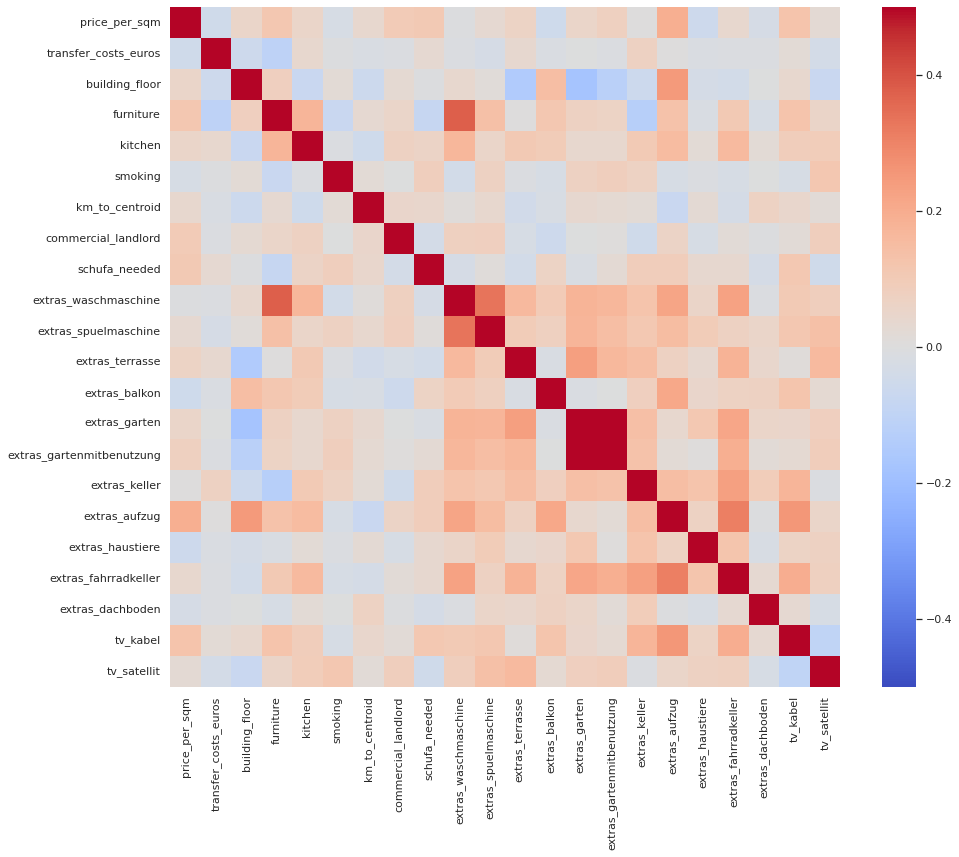

In [59]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 12.5))

sns.heatmap(df_city.corr(), cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-0.5, vmax=0.5);

In [60]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()

df["features"] = columns_to_zscore

df["vif_index"] = [vif(df_city[columns_to_zscore].values, i) for i in range(df_city[columns_to_zscore].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)

,features,vif_index
2,furniture,1.06
3,kitchen,1.05
1,building_floor,1.02
0,transfer_costs_euros,1.02
5,km_to_centroid,1.01
4,smoking,1.01


In [61]:
# OLS model
formula = target + ' ~ ' + ' + '.join(selected_num_features) + ' + ' + ' + '.join(['C('+feat+')-1' for feat in selected_cat_features]) + '-1'

model_city = smf.ols(formula = formula, data=df_city).fit()
model_city.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          price_per_sqm   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     7.109
Date:                Thu, 25 Aug 2022   Prob (F-statistic):           1.62e-39
Time:                        19:45:46   Log-Likelihood:                -2377.1
No. Observations:                 699   AIC:                             4870.
Df Residuals:                     641   BIC:                             5134.
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
C(city)[Aachen]                         17.6563      1.993      8.859      0.000      13.743      21.570
C(city)[Berlin]                         20.3012      1.319     15.387      0.000      17.710      22.892
C(city)[Bonn]                           20.4455      2.575      7.941      0.000      15.390      25.501
C(city)[Bremen]                         14.4446      2.520      5.732      0.000       9.496      19.393
C(city)[Darmstadt]                      20.6700      3.475      5.948      0.000      13.846      27.494
C(city)[Dresden]                        12.6932      2.349      5.403      0.000       8.080      17.307
C(city)[Frankfurt am Main]              23.4532      1.949     12.031      0.000      19.625      27.281
C(city)[Göttingen]                      13.1676      2.480      5.310      0.000       8.298      18.037
C(city)[Hamburg]                        30.4857      3.333      9.147      0.000      23.941      37.030
C(city)[Hannover]                       14.6074      2.732      5.346      0.000       9.242      19.972
C(city)[Heidelberg]                     19.4676      2.109      9.232      0.000      15.327      23.608
C(city)[Karlsruhe]                      15.8597      2.104      7.538      0.000      11.728      19.991
C(city)[Kiel]                           17.8135      4.674      3.811      0.000       8.636      26.991
C(city)[Köln]                           21.0599      1.511     13.933      0.000      18.092      24.028
C(city)[Leipzig]                        13.5217      2.126      6.362      0.000       9.348      17.696
C(city)[Mainz]                          16.8076      2.664      6.310      0.000      11.577      22.038
C(city)[Mannheim]                       16.1254      2.258      7.142      0.000      11.692      20.559
C(city)[München]                        30.6081      1.623     18.854      0.000      27.420      33.796
C(city)[Münster]                        15.8361      2.488      6.364      0.000      10.950      20.722
C(city)[Nürnberg]                       16.5168      2.542      6.498      0.000      11.526      21.508
C(city)[Regensburg]                     17.8718      2.413      7.408      0.000      13.134      22.609
C(city)[Stuttgart]                      18.8351      2.045      9.211      0.000      14.820      22.851
C(city)[Tübingen]                       15.8401      4.186      3.784      0.000       7.620      24.060
C(city)[Würzburg]                       16.3682      2.498      6.554      0.000      11.464      21.273
C(commercial_landlord)[T.1]             -2.1842      3.780     -0.578      0.564      -9.606       5.238
C(rental_length_term)[T.<270days]        0.8268      1.521      0.544      0.587      -2.159       3.813
C(rental_length_term)[T.<365days]     

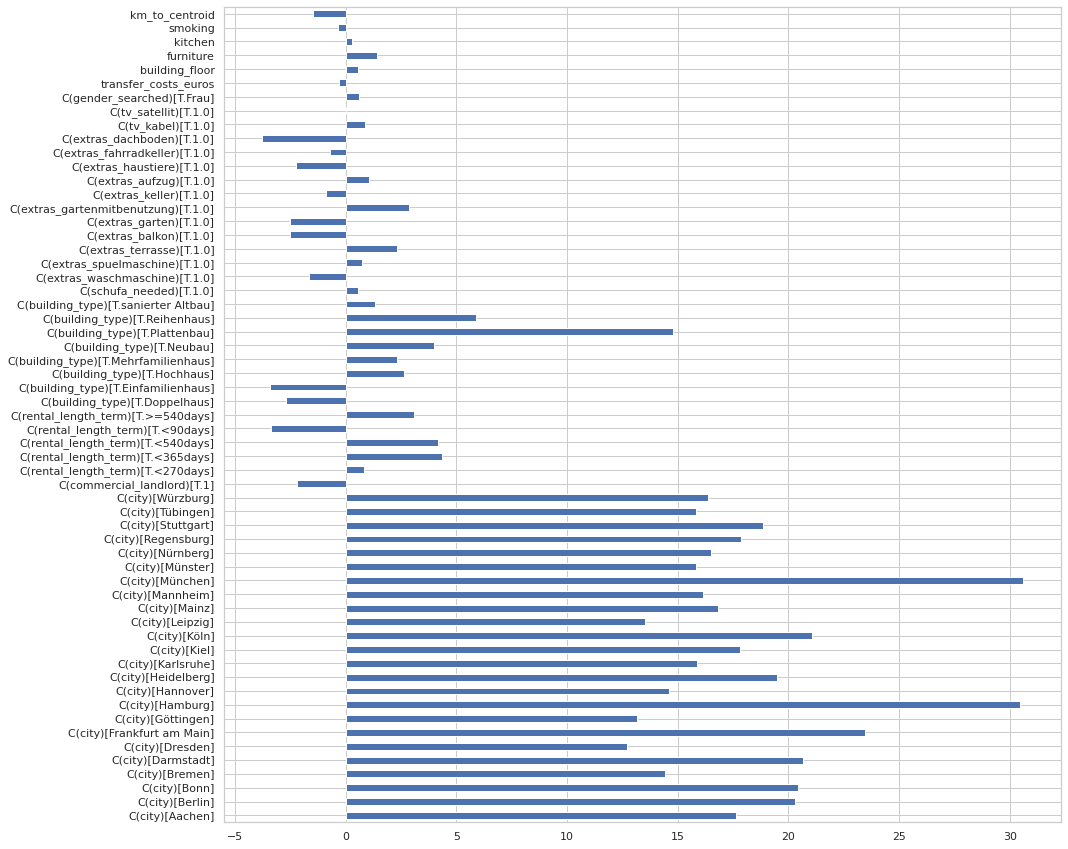

In [62]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model_city.params[0:].plot(kind='barh');

RMSE: 7.255268738789241
RMSE base model: 9.269129497747112


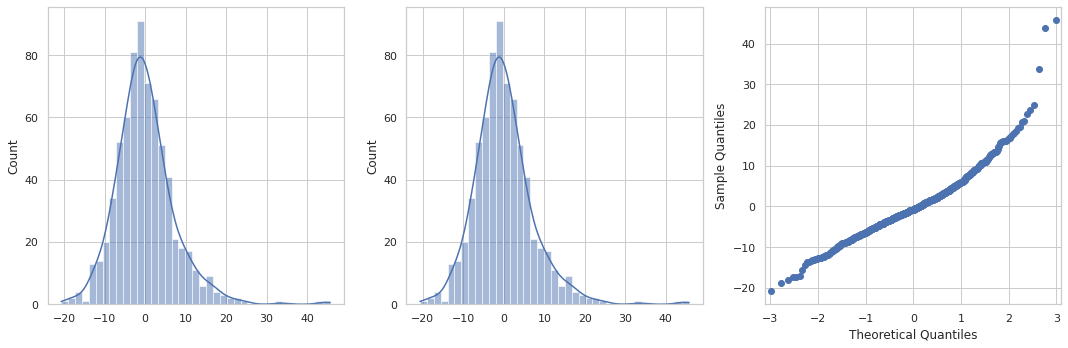

In [63]:
y_pred = model_city.predict(df_city)
y_base = [np.mean(df_city['price_per_sqm'])]*len(y_pred)
y_true = df_city['price_per_sqm']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_city)
residuals = y_pred - y_true
residuals_base = y_pred - y_true
# residuals.std()/orders.delay_vs_expected.std() * 1/(n**0.5)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(-residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(-residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model_city.resid, ax=ax3)
plt.tight_layout()
fig.show();

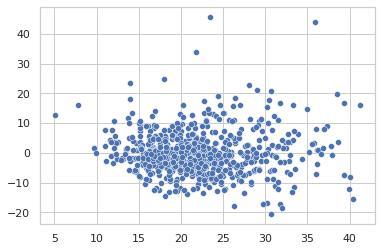

In [64]:
sns.scatterplot(x=model_city.predict(df_city), y=model_city.resid);

                                           p_value       coef
variable                                                     
C(city)[München]                      2.050396e-63  30.608066
C(city)[Hamburg]                      7.658419e-19  30.485714
C(city)[Frankfurt am Main]            3.331709e-30  23.453222
C(city)[Köln]                         9.718388e-39  21.059851
C(city)[Darmstadt]                    4.473658e-09  20.669980
C(city)[Bonn]                         8.984648e-15  20.445492
C(city)[Berlin]                       1.068631e-45  20.301204
C(city)[Heidelberg]                   3.811046e-19  19.467628
C(city)[Stuttgart]                    4.556693e-19  18.835065
C(city)[Regensburg]                   4.064417e-13  17.871819
C(city)[Kiel]                         1.514588e-04  17.813531
C(city)[Aachen]                       7.906882e-18  17.656279
C(city)[Mainz]                        5.219828e-10  16.807565
C(city)[Nürnberg]                     1.632221e-10  16.516770
C(city)[

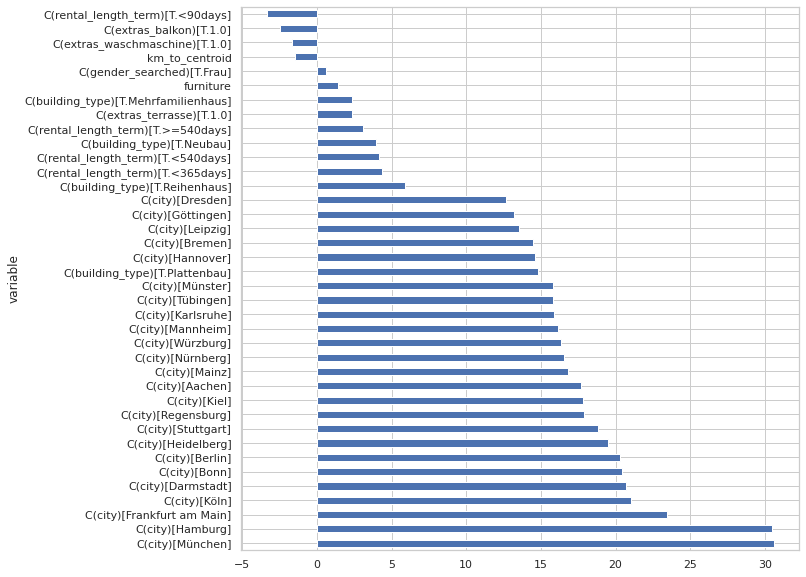

In [65]:
df = return_significative_coef(model_city).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef.plot(kind='barh');